# 핫플 정의 실습

## 문제의식
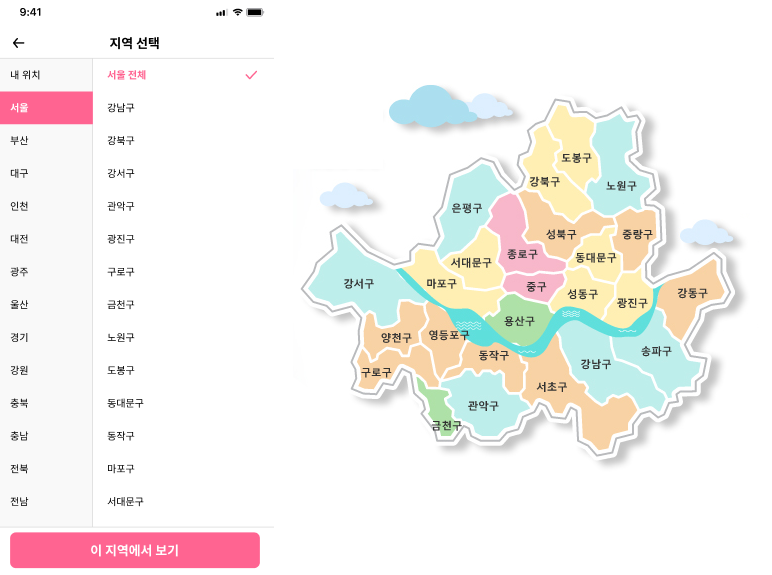

- 현 지역단위: 지역구, 읍면동 단위의 구분 -> 서비스 운영관점에서 편리
- 하지만 유저의 관점에서는 직관적이지 않음 -> 서울 사람도 건대입구, 샤로수길, 홍대입구, 영등포타임스퀘어가 무슨 동인지 알기 어려움
- 어떻게 하면 유저친화적으로 개선할 수 있을까?


## 실습주제
- 지역단위를 어떻게 정의할 것인가? (지역단위의 총 개수, 각 지역단위의 포함범위)
- 어떤 핫플들을 선정할 것인가? (상권을 어떻게 묶을 것인가? 떠오르는 핫플이 있는가?)
  

## 활용데이터
- 상권별 인구데이터 <- 제공
- 상권별 매출데이터 <- 제공
- 상권코드 자료(seoul_v3.xlsx) <- 제공
- +a

# 데이터 불러와서 데이터프레임 만들기

In [ ]:
# 그래프 한글 깨짐 방지용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 상권매출 데이터
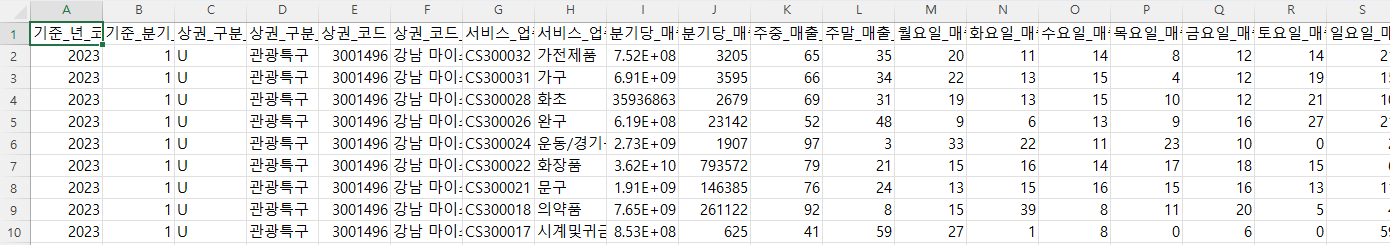

- 2023년 각 상권의 매출 데이터
- 상권구분, 업종구분
- 주말/주중/요일별 매출
- 성별/연령대별 매출

In [ ]:
# 상권 매출
sales1 = pd.read_csv('상권별 추정매출.csv',  encoding='cp949')
sales1['상권_코드_명'] = sales1['상권_코드_명'].str.replace(' ','')
sales1['상권_코드_명'] = sales1['상권_코드_명'].str.replace('\n','')
sales1.info()

## 생활인구수 데이터
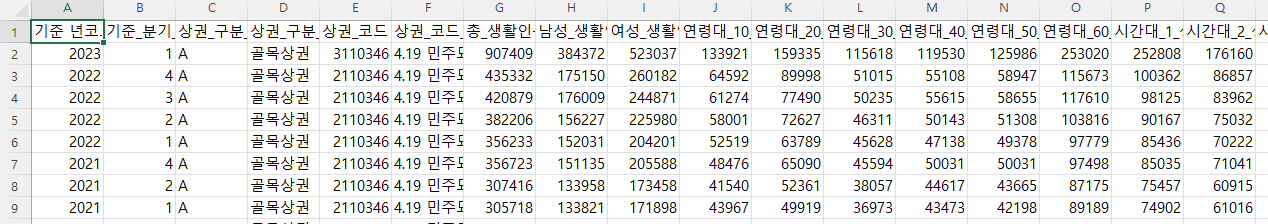

- 2017~2023년 각 상권의 생활인구수 데이터
- 상권구분O, 업종구분X
- 성별/연령대별 인구수
- 요일/시간대별 인구

In [ ]:
# 상권 생활인구 수
population1 = pd.read_csv('상권별 생활인구.csv',  encoding='cp949')
population1['상권_코드_명'] = population1['상권_코드_명'].str.replace(' ','')
population1['상권_코드_명'] = population1['상권_코드_명'].str.replace('\n','')
population1.info()

## 상권정보 데이터
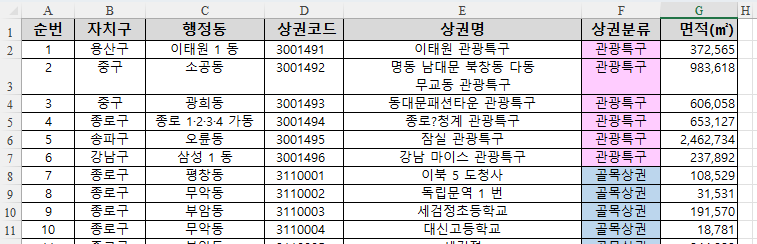

- 상권매출, 생활인구수 데이터에는 자치구, 행정동 구분이 없어, 단일 데이터파일만으로는 지역단위 별 분석에 어려움이 있음
- 각 상권의 자치구,행정동을 정의하기 위한 목적으로 이용 상권정보 데이터를 활용

In [ ]:
# 상권 정보
area = pd.read_excel('상권영역.xlsx')
area['상권명'] = area['상권명'].str.replace(' ','')
area['상권명'] = area['상권명'].str.replace('\n','')
area.head()
area.info()

# 상권 정보를 데이터프레임에 추가하기

- `상권코드`를 이용해 매출정보-지역정보 / 인구수정보-지역정보를 merge

In [ ]:
# 매출 데이터에 상권 정보 추가하기
sales = pd.merge(area, sales1, left_on='상권코드', right_on='상권_코드')
sales = sales.drop(['상권_구분_코드_명', '상권_코드', '상권_코드_명'], axis=1)
sales.head()

In [ ]:
# 인구 데이터에 상권 정보 추가하기
population = pd.merge(area, population1, left_on='상권명', right_on='상권_코드_명')
population = population.drop(['상권_구분_코드_명', '상권_코드', '상권_코드_명'], axis=1)
population.head()

# 결측치 확인하기
- 결측치 발생시, 결측치를 보완하거나 해당 row를 제거

In [ ]:
# 매출 데이터 결측치 확인 -> 결측치 없음.
sales.info()

In [ ]:
# 인구 데이터 결측치 확인 - column 이 너무 많아 info 로 확인 불가
population.info()

In [ ]:
# column 별 결측치 수 확인 - column 이 너무 많아 전체 확인 불가
null_counts = population.isnull().sum()
null_counts

In [ ]:
# 한 column 이라도 결측치가 있는 row 를 전부 출력 -> 결측치 없음을 확인.
population[population.isnull().any(axis=1)]

# 데이터 시각화

## 자치구별 상권 개수, 자치구별 관광특구/전통시장/발달상권/골목상권 개수

In [ ]:
# 자치구별 총 상권 수 시각화
cd_num = area.groupby('자치구')['상권코드'].count().reset_index()
cd_num = pd.DataFrame(cd_num)
cd_num.columns = ['자치구', '상권수']

plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(data = cd_num, x='자치구', y='상권수', ci=None )
plt.title('자치구별 총 상권 수', fontdict={'fontsize': 14})

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로
            p.get_y() + p.get_height()+1 ,   # 세로
            f"{p.get_height():.0f}",
            fontsize = 12,
            ha = 'center' )

### 논의점(분석요인, 비즈니스 적용방안 등) 도출해보기
- 강남구는 상권이 많으니까 강남구 내부에서 지역단위를 더 쪼개는 것이 좋을 수도 있겠다
- 노원구, 도봉구는 상권 개수가 적고, 서로 붙어있으니까 지역단위를 합치는게 좋을 수도 있겠다
- 아니다, 한 지역구에 상권 개수가 30개인 것도 충분히 많다
- +a

In [ ]:
# 자치구별 총 상권 수와 유형별 상권 개수 시각화
cd_num = area.groupby(['자치구', '상권분류'])['상권코드'].count().reset_index()
cd_num = pd.DataFrame(cd_num)
cd_num.columns = ['자치구', '상권분류', '상권수']

pivot_df = cd_num.pivot(index='자치구', columns='상권분류', values='상권수')
ax = pivot_df.plot.bar(stacked=True, figsize=(16,9), color = ['lightsalmon', 'yellow', 'skyblue', 'lightgreen'])
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.0f"%(height), xy=(left+width/2, bottom+height/2), ha='center', va='center', fontsize = 11)
plt.legend(fontsize=11)
plt.xticks(rotation=0)
plt.title('자치구별 총 상권 수와 유형별 상권 개수', fontdict={'fontsize': 14})


In [ ]:
# 자치구별 유형별 상권 개수 시각화
plt.figure(figsize=(24,9))
plt.title('자치구별 유형별 상권 개수', fontdict={'fontsize': 14})

ax = sns.barplot(data = cd_num, x='자치구', y='상권수', hue='상권분류', palette='Accent')
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate("%.0f"%(height), (left+width/2, height*1.01), ha='center', fontsize = 11)

### 논의점(분석요인, 비즈니스 적용방안 등) 도출해보기
- 관광특구가 없는 지역구가 많다. -> ?
- 거의 모든 지역구에서 골목상권이 전체의 절반 이상을 차지 -> ?
- 발달상권이 더 많은 지역구 VS 전통시장이 더 많은 지역구 -> ?
- +a



## 총 매출액 top10의 총 매출액 시각화, 총 생활인구수 top10의 총 생활인구수

In [ ]:
# 총 매출액 top 10 시각화
sales10 = sales.sort_values('분기당_매출_금액', ascending=False)[['상권명','분기당_매출_금액']].iloc[:20]
sales10 = sales10.drop_duplicates(['상권명']).iloc[:10]

plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(data = sales10, x='상권명', y='분기당_매출_금액', ci=None , palette='Pastel1')
plt.title('2023 총 매출액 top 10', fontdict={'fontsize': 14})

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로
            p.get_y() + p.get_height() + 10000000000 ,   # 세로
            f"{p.get_height():.0f}",
            fontsize = 11,
            ha = 'center' )

### 논의점(분석요인, 비즈니스 적용방안 등) 도출해보기
-

In [ ]:
# 총 생활인구 top 10 시각화
population10 = population.sort_values('총_생활인구_수', ascending=False)[['상권명','총_생활인구_수']].iloc[:100]
population10 = population10.drop_duplicates(['상권명']).iloc[:10]

plt.rc('font', family='NanumBarunGothic')
fig, ax = plt.subplots(figsize=(20,9))
sns.barplot(data = population10, x='상권명', y='총_생활인구_수', ci=None , palette='Pastel2')
plt.title('2023 총 생활인구 top 10', fontdict={'fontsize': 14})

for p in ax.patches:
    ax.text(p.get_x() + (p.get_width()/2) ,   # 가로
            p.get_y() + p.get_height()+100000 ,   # 세로
            f"{p.get_height():.0f}",
            fontsize = 11,
            ha = 'center' )

### 논의점(분석요인, 비즈니스 적용방안 등) 도출해보기
-

## 자치구별 지난 5년간 총 생활인구 수 변화 시각화

In [ ]:
# 자치구별 지난 5년의 총 생활인구 수
# 25개 분기(2017-1 ~ 2023-1) 의 데이터가 없는 예외 상권 3곳을 제거하고 생활인구 수를 더함.
aa = population['상권명'].value_counts().reset_index()
remove_list = aa[aa['상권명']!=25]['index']
r_population = population[~population['상권명'].isin(remove_list)]

total_pop = r_population.groupby(['자치구', '기준 년코드'])['총_생활인구_수'].sum().reset_index()
total_pop = total_pop[total_pop['기준 년코드']!=2023]
total_pop

In [ ]:
# 자치구별 지난 5년간 총 생활인구 수 변화 시각화
grouped = total_pop.groupby('자치구')

plt.figure(figsize=(16,9))
for name, group in grouped:
    plt.plot(group['기준 년코드'], group['총_생활인구_수'], label=f'{name}', linewidth = 1.5)

plt.xlabel('연도')
plt.ylabel('총 생활인구 수')
plt.title('자치구 별 생활인구 수 변화')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.grid(True)
plt.show()

## 관광특구별 지난 5년간 20대 생활인구 수 변화 시각화

In [ ]:
# 관광특구별 지난 5년의 20대 생활인구 수
sp_population = population[population['상권분류']=='관광특구']
total20_pop = sp_population.groupby(['상권명', '기준 년코드'])['연령대_20_생활인구_수'].sum().reset_index()
total20_pop = total20_pop[total20_pop['기준 년코드']!=2023]
total20_pop

In [ ]:
# 관광특구별 지난 5년간 20대 생활인구 수 변화 시각화
grouped = total20_pop.groupby('상권명')

plt.figure(figsize=(16,9))
for name, group in grouped:
    plt.plot(group['기준 년코드'], group['연령대_20_생활인구_수'], label=f'{name}', linewidth = 2)

plt.xlabel('연도')
plt.ylabel('20대 생활인구 수')
plt.title('관광특구 20대 생활인구 수 변화')
plt.legend()
plt.grid(True)
plt.show()

### 논의점(분석요인, 비즈니스 적용방안 등) 도출해보기
-

## 광진구 발달상권들의 지난 5년간 20대 생활인구 수 변화 시각화

In [ ]:
# 광진구 발달상권들의 지난 5년의 20대 생활인구 수
spp_population = population[(population['상권분류']=='발달상권') & (population['자치구']=='광진구')]
ttotal20_pop = spp_population.groupby(['상권명', '기준 년코드'])['연령대_20_생활인구_수'].sum().reset_index()
ttotal20_pop = ttotal20_pop[ttotal20_pop['기준 년코드']!=2023]
ttotal20_pop

In [ ]:
# 광진구 발달상권들의 지난 5년간 20대 생활인구 수 변화 시각화
grouped = ttotal20_pop.groupby('상권명')

plt.figure(figsize=(16,9))
for name, group in grouped:
    plt.plot(group['기준 년코드'], group['연령대_20_생활인구_수'], label=f'{name}', linewidth = 2)

plt.xlabel('연도')
plt.ylabel('20대 생활인구 수')
plt.title('광진구 발달상권 20대 생활인구 수 변화')
plt.legend(loc='upper left', bbox_to_anchor=(1.0,1.0))
plt.grid(True)
plt.show()